# Importações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import io
import requests
import zipfile
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.utils import make_grid
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryAccuracy
from PIL import Image
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Funções do Projeto

In [2]:
def calc_foreground_ratio(mask):
    mask_bin = (mask > 0.5).astype(np.uint8)
    return np.sum(mask_bin) / mask_bin.size

In [3]:
def show_image_with_mask(img, mask=None, figsize=(12, 4)):

    plt.figure(figsize=(figsize))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    if mask is not None:
        plt.imshow(mask, cmap='Reds', alpha=0.5)
        plt.title('Image + Mask')
    else:
        plt.title('Image (without mask)')

    plt.tight_layout()
    plt.show()

In [4]:
def normalizing(img):
    return np.array(img) / 255.0

In [5]:
def center_crop(img, output_size):

    if img.shape[0] < output_size[0] or img.shape[1] < output_size[1]:
        raise ValueError("Imagem menor que o tamanho de recorte desejado.")

    img = np.array(img)
    starty = (img.shape[0] - output_size[0]) // 2
    startx = (img.shape[1] - output_size[1]) // 2
    cropped_img = img[starty:starty + output_size[0], startx:startx + output_size[1]]
    
    return cropped_img

In [6]:
def shape_process(img, input_size):

    if img.shape[0] > input_size[0] or img.shape[1] > input_size[1]:
        raise ValueError('Dimensões da imagem são maiores que o "input_size"')

    if img.shape[0] % 2:
        img = cv2.resize(img, img.shape[0] // 2, interpolation=cv2.INTER_CUBIC)
    padd = int((input_size[0] - img.shape[0]) / 2)
    img = cv2.copyMakeBorder(img, padd, padd, padd, padd, cv2.BORDER_REFLECT_101)
    return img

In [7]:
def evaluate_metrics(prediction, ground_truth, threshold=0.5):

    iou_jaccard = BinaryJaccardIndex()
    f1_score = BinaryF1Score()
    pixel_accuracy = BinaryAccuracy()

    pred_bin = (prediction > threshold).int().squeeze().cpu()
    gt_bin = torch.from_numpy(ground_truth).int().squeeze()

    if pred_bin.shape != gt_bin.shape:
        raise ValueError(f"Shape incompatível: pred {pred_bin.shape}, gt {gt_bin.shape}")

    metrics = {
        'IoU': iou_jaccard(pred_bin, gt_bin).item(),
        'F1 Score': f1_score(pred_bin, gt_bin).item(),
        'Pixel Accuracy': pixel_accuracy(pred_bin, gt_bin).item()
    }

    return metrics

# Importação do Dados

In [8]:
zip_file_url = 'data.zip'

In [9]:
with open(zip_file_url, 'rb') as f:
    zip_file_bytes = io.BytesIO(f.read()) 

test_images = []
train_labels = []
train_images = []

with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
    sorted_files = sorted(zip_ref.namelist())
    for file_name in sorted_files:
        if file_name.endswith('.tif'):
            with zip_ref.open(file_name) as file:
                img = Image.open(file).convert('L')
                img_array = np.array(img)
                if '/train/images/' in file_name:
                    train_images.append(img_array)
                elif '/train/labels/' in file_name:
                    train_labels.append(img_array)
                elif '/test/' in file_name:
                    test_images.append(img_array)

In [10]:
print(f'Size Train Images: {len(train_images)}')
print(f'Size Train Labels: {len(train_labels)}')
print(f'Size Test Images: {len(test_images)}')

Size Train Images: 30
Size Train Labels: 30
Size Test Images: 30


# EDA

In [11]:
train_images[0], train_images[0].shape

(array([[126, 107, 122, ..., 161, 164, 177],
        [138, 118, 123, ..., 153, 149, 153],
        [141, 135, 145, ..., 144, 145, 137],
        ...,
        [155, 149, 168, ..., 139, 115, 120],
        [163, 154, 166, ..., 158, 141, 148],
        [151, 141, 160, ..., 183, 164, 171]], dtype=uint8),
 (512, 512))

In [12]:
train_labels[0], train_labels[0].shape

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 (512, 512))

In [13]:
test_images[0], test_images[0].shape

(array([[176, 161, 169, ..., 127, 155, 189],
        [197, 190, 187, ..., 119, 115, 154],
        [185, 181, 203, ..., 140, 103, 122],
        ...,
        [123, 132, 103, ..., 154, 187, 246],
        [ 98,  94, 124, ..., 166, 187, 208],
        [115,  67, 125, ..., 208, 196, 157]], dtype=uint8),
 (512, 512))

In [14]:
shape = (512, 512)
diff_shape_train_images = [i if img.shape != shape else 0 for i, img in enumerate(train_images)]
diff_shape_train_labels = [i if img.shape != shape else 0 for i, img in enumerate(train_labels)]
diff_shape_test_images = [i if img.shape != shape else 0 for i, img in enumerate(test_images)]

In [15]:
print(f'Image Train with different shape:')
print(diff_shape_train_images)
print(f'Label Train with different shape:')
print(diff_shape_train_labels)
print(f'Image Test with different shape:')
print(diff_shape_test_images)

Image Train with different shape:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label Train with different shape:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Image Test with different shape:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
ratios = [calc_foreground_ratio(label) for label in train_labels]
print(f'Average Foreground Ratio: {np.mean(ratios):.4f}')
print(f'Minimum proportion: {np.min(ratios):.4f}')
print(f'Maximum proportion: {np.max(ratios):.4f}')

Average Foreground Ratio: 0.7804
Minimum proportion: 0.7301
Maximum proportion: 0.8325


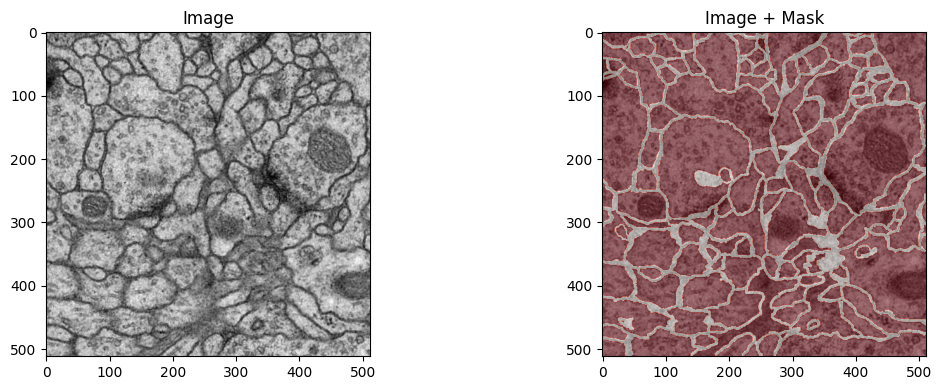

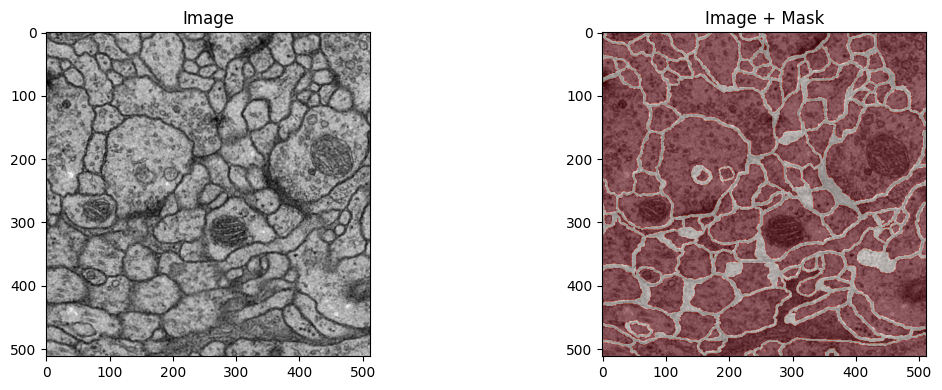

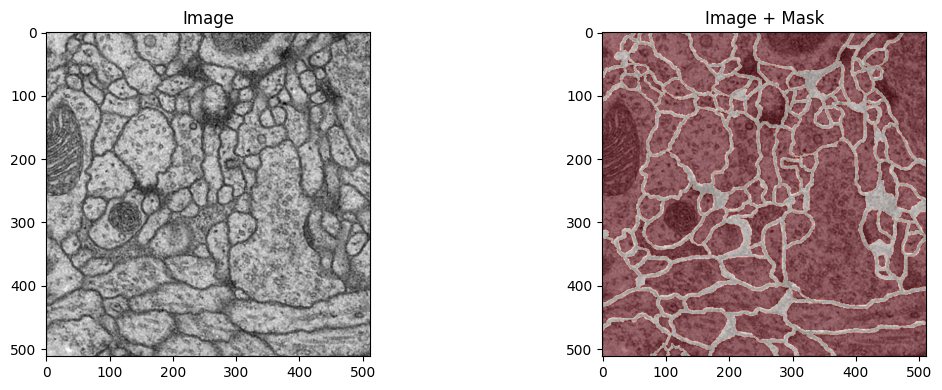

In [17]:
for c in range(3):
    show_image_with_mask(train_images[c], train_labels[c])

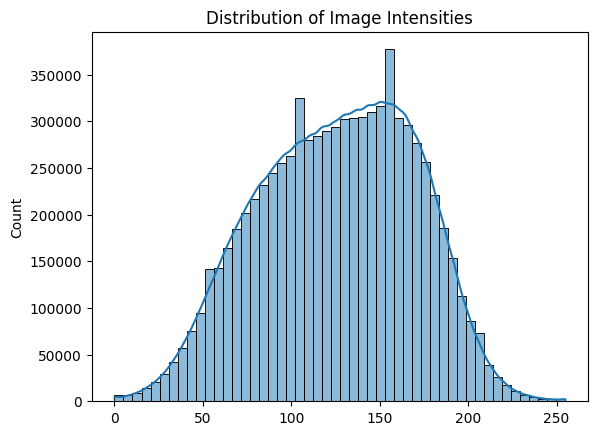

In [18]:
pixels = np.concatenate([img.flatten() for img in train_images])
sns.histplot(pixels, bins=50, kde=True)
plt.title('Distribution of Image Intensities')
plt.show();

In [19]:
total_foreground = sum(np.sum(mask > 0.5) for mask in train_labels)
total_pixels = len(train_labels) * 512 * 512
print(f'Total proportion of segmented pixels: {total_foreground / total_pixels:.4f}')

Total proportion of segmented pixels: 0.7804


In [20]:
fg_pixel_values = [img[mask > 0] for img, mask in zip(train_images, train_labels)]
all_fg_pixels = np.concatenate(fg_pixel_values)

In [21]:
print(f'Medium foreground intensity: {np.mean(all_fg_pixels):.2f}')
print(f'Standard deviation: {np.std(all_fg_pixels):.2f}')

Medium foreground intensity: 137.66
Standard deviation: 39.70


# Processamento

In [22]:
train_images_norm = [normalizing(shape_process(img, (572,572))) for img in train_images]
test_images_norm = [normalizing(shape_process(img, (572,572))) for img in test_images]
train_labels_norm = [(normalizing(center_crop(img, (388,388))) > 0.5).astype(int) for img in train_labels]

In [23]:
train_images_process = np.asarray(train_images_norm, dtype=np.float32)[:,:,:, np.newaxis]
test_images_process = np.asarray(test_images_norm, dtype=np.float32)[:,:,:, np.newaxis]
train_labels_process = np.asarray(train_labels_norm, dtype=np.float32)[:,:,:, np.newaxis]

In [24]:
test_images_process[0], test_images_process.shape

(array([[[0.42745098],
         [0.29803923],
         [0.43137255],
         ...,
         [0.3764706 ],
         [0.13333334],
         [0.1764706 ]],
 
        [[0.38039216],
         [0.39215687],
         [0.44705883],
         ...,
         [0.36078432],
         [0.29803923],
         [0.42745098]],
 
        [[0.48235294],
         [0.50980395],
         [0.6       ],
         ...,
         [0.3372549 ],
         [0.36078432],
         [0.40784314]],
 
        ...,
 
        [[0.34117648],
         [0.3764706 ],
         [0.2901961 ],
         ...,
         [0.75686276],
         [0.49803922],
         [0.44313726]],
 
        [[0.46666667],
         [0.3882353 ],
         [0.33333334],
         ...,
         [0.6156863 ],
         [0.60784316],
         [0.5686275 ]],
 
        [[0.32156864],
         [0.2509804 ],
         [0.21960784],
         ...,
         [0.49019608],
         [0.69803923],
         [0.65882355]]], dtype=float32),
 (30, 572, 572, 1))

In [25]:
train_images_process[0], train_images_process.shape

(array([[[0.7490196 ],
         [0.76862746],
         [0.7607843 ],
         ...,
         [0.43529412],
         [0.41568628],
         [0.4117647 ]],
 
        [[0.6666667 ],
         [0.67058825],
         [0.68235296],
         ...,
         [0.5372549 ],
         [0.42352942],
         [0.39215687]],
 
        [[0.4862745 ],
         [0.47058824],
         [0.54901963],
         ...,
         [0.49019608],
         [0.3647059 ],
         [0.39607844]],
 
        ...,
 
        [[0.73333335],
         [0.6901961 ],
         [0.7294118 ],
         ...,
         [0.36078432],
         [0.38431373],
         [0.42745098]],
 
        [[0.7019608 ],
         [0.654902  ],
         [0.6431373 ],
         ...,
         [0.43137255],
         [0.41568628],
         [0.4627451 ]],
 
        [[0.6901961 ],
         [0.654902  ],
         [0.62352943],
         ...,
         [0.5529412 ],
         [0.48235294],
         [0.5294118 ]]], dtype=float32),
 (30, 572, 572, 1))

In [26]:
train_labels_process[0], train_labels_process.shape

(array([[[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],
 
        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]], dtype=float32),
 (30, 388, 388, 1))

# Construção da Rede Neural

In [27]:
class Segmentation_UNet(nn.Module):

    def __init__(self):
        super(Segmentation_UNet, self).__init__()

        self.conv1 = self.double_conv(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = self.double_conv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(256 + 256, 256)

        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(128 + 128, 128)

        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(64 + 64, 64)

        self.conv10 = nn.Conv2d(in_channels= 64, out_channels=1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, source_tensor, target_shape):
        start_y = (source_tensor.shape[2] - target_shape[2]) // 2
        start_x = (source_tensor.shape[3] - target_shape[3]) // 2

        return source_tensor[:,:, start_y:start_y + target_shape[2], start_x:start_x + target_shape[3]]

    def forward(self, x):

        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        x = self.conv5(p4)

        x = self.up_conv1(x)
        x = torch.cat((self.center_crop(c4, x.shape), x), dim=1)
        x = self.conv6(x)

        x = self.up_conv2(x)
        x = torch.cat((self.center_crop(c3, x.shape), x), dim=1)
        x = self.conv7(x)

        x = self.up_conv3(x)
        x = torch.cat((self.center_crop(c2, x.shape), x), dim=1)
        x = self.conv8(x)

        x = self.up_conv4(x)
        x = torch.cat((self.center_crop(c1, x.shape), x), dim=1)
        x = self.conv9(x)

        output = torch.sigmoid(self.conv10(x))

        return output

# Visualizando a Estrutura de Rede Neural

In [28]:
model = Segmentation_UNet()
print(model)

Segmentation_UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  

# Configurações Adicionais

## Carregando o Modelo na GPU

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

Using cuda device.


## Inspeção da Saída de Cada Camada da Rede Neural

In [30]:
input_tensor = torch.randn(1, 1, 572, 572)

def print_size(module, input, output):
    print(f'{module.__class__.__name__} output size: {output.size()}')

for layer in model.children():
    layer.register_forward_hook(print_size)

with torch.no_grad():
    output = model(input_tensor)

print(f'Final output size: {output.size()}')

Sequential output size: torch.Size([1, 64, 568, 568])
MaxPool2d output size: torch.Size([1, 64, 284, 284])
Sequential output size: torch.Size([1, 128, 280, 280])
MaxPool2d output size: torch.Size([1, 128, 140, 140])
Sequential output size: torch.Size([1, 256, 136, 136])
MaxPool2d output size: torch.Size([1, 256, 68, 68])
Sequential output size: torch.Size([1, 512, 64, 64])
MaxPool2d output size: torch.Size([1, 512, 32, 32])
Sequential output size: torch.Size([1, 1024, 28, 28])
ConvTranspose2d output size: torch.Size([1, 512, 56, 56])
Sequential output size: torch.Size([1, 512, 52, 52])
ConvTranspose2d output size: torch.Size([1, 256, 104, 104])
Sequential output size: torch.Size([1, 256, 100, 100])
ConvTranspose2d output size: torch.Size([1, 128, 200, 200])
Sequential output size: torch.Size([1, 128, 196, 196])
ConvTranspose2d output size: torch.Size([1, 64, 392, 392])
Sequential output size: torch.Size([1, 64, 388, 388])
Conv2d output size: torch.Size([1, 1, 388, 388])
Final output si

## Criação do DataLoaders para o Treinamento

In [31]:
batch_size = 1

train_tensor = torch.from_numpy(train_images_process[:6]).permute(0, 3, 1, 2).float().to(device)
train_groundtruth_tensor = torch.from_numpy(train_labels_process[:6]).permute(0, 3, 1, 2).float().to(device)

dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

torch.manual_seed(42)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Configurando a Early Stopping

In [32]:
class EarlyStopping:

    def __init__(self, patience=5, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if (self.best_loss is None) or (val_loss < self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# Treinamento do Modelo

In [33]:
model = Segmentation_UNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 30

early_stopping = EarlyStopping(patience=3, min_delta=0.005)

train_losses = []
val_losses = []

for e in tqdm(range(epochs), leave=True, desc='Epoch'):
    model.train()
    epoch_train_loss = 0

    for data, labels in tqdm(train_dl, leave=True, desc='   Training Dataset'):
        optim.zero_grad()
        prediction = model(data)
        loss = F.mse_loss(prediction, labels)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()

    average_train_loss = epoch_train_loss / len(train_dl)
    train_losses.append(average_train_loss)

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for data, labels in tqdm(val_dl, leave=False, desc='   Validation Dataset'):
            prediction = model(data)
            loss = F.mse_loss(prediction, labels)
            epoch_val_loss += loss.item()

    average_val_loss = epoch_val_loss / len(val_dl)
    val_losses.append(average_val_loss)

    print(f'Epoch: {e+1}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')
        
    best = early_stopping(average_val_loss)

    if best:
        torch.save(model.state_dict(), 'best_model.pth')
    
    if early_stopping.early_stop:
        print('Applied Early Stopping')
        break

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.2435, Val Loss: 0.2398


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.2390, Val Loss: 0.2351


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.2344, Val Loss: 0.2294


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.2281, Val Loss: 0.2210


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.2187, Val Loss: 0.2065


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.2009, Val Loss: 0.1736


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.1893, Val Loss: 0.1709


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.1803, Val Loss: 0.1715


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.1789, Val Loss: 0.1679


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.1765, Val Loss: 0.1647


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.1747, Val Loss: 0.1628


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.1725, Val Loss: 0.1610


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.1702, Val Loss: 0.1590


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 0.1678, Val Loss: 0.1565


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15, Train Loss: 0.1649, Val Loss: 0.1526


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 0.1615, Val Loss: 0.1488


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 0.1579, Val Loss: 0.1459


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 0.1531, Val Loss: 0.1398


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 0.1475, Val Loss: 0.1334


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20, Train Loss: 0.1428, Val Loss: 0.1256


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21, Train Loss: 0.1350, Val Loss: 0.1205


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22, Train Loss: 0.1319, Val Loss: 0.1166


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23, Train Loss: 0.1236, Val Loss: 0.1081


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24, Train Loss: 0.1270, Val Loss: 0.1058


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 25, Train Loss: 0.1224, Val Loss: 0.1081


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 26, Train Loss: 0.1242, Val Loss: 0.1018


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 27, Train Loss: 0.1150, Val Loss: 0.1054


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 28, Train Loss: 0.1182, Val Loss: 0.1058


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 29, Train Loss: 0.1179, Val Loss: 0.1005
Applied Early Stopping


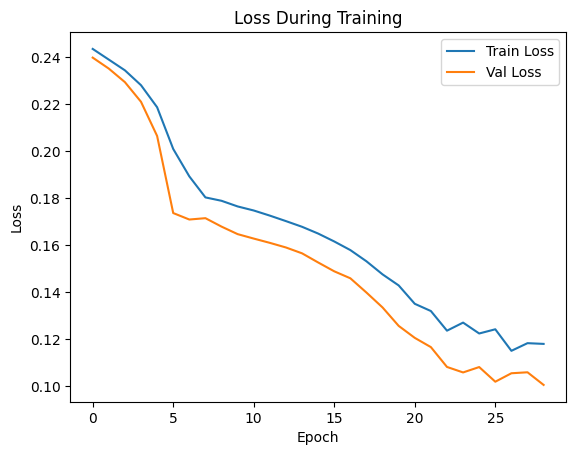

In [34]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Carregando e Avaliando o Modelo

In [35]:
model = Segmentation_UNet().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device(device)))
model.eval()

Segmentation_UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  

### Testando com uma imagem da base de treinamento

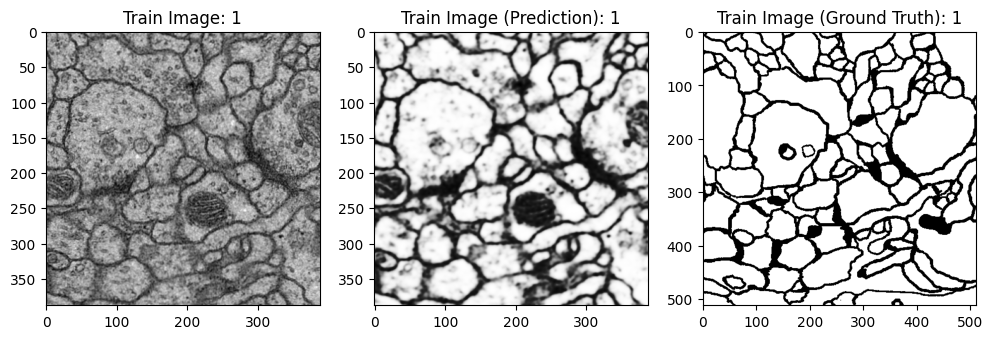

In [36]:
sample_image_index = 1

predictions = []
test_tensor = torch.from_numpy(train_images_process[sample_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(center_crop(train_images_process[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 3, 2)
plt.imshow(make_grid(prediction.cpu())[0].numpy(), cmap='gray')
plt.title(f'Train Image (Prediction): {sample_image_index}')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()

In [37]:
with torch.no_grad():
    prediction = model(test_tensor)

metrics = evaluate_metrics(prediction.cpu(), train_labels_process[sample_image_index])

print(f'IoU (Intersection over Union) / Jaccard Index: {metrics['IoU']:.4f}')
print(f'Dice Coefficient (F1-Score for Pixels): {metrics['F1 Score']:.4f}')
print(f'Pixel Accuracy: {metrics['Pixel Accuracy']:.4f}')

IoU (Intersection over Union) / Jaccard Index: 0.8123
Dice Coefficient (F1-Score for Pixels): 0.8964
Pixel Accuracy: 0.8426


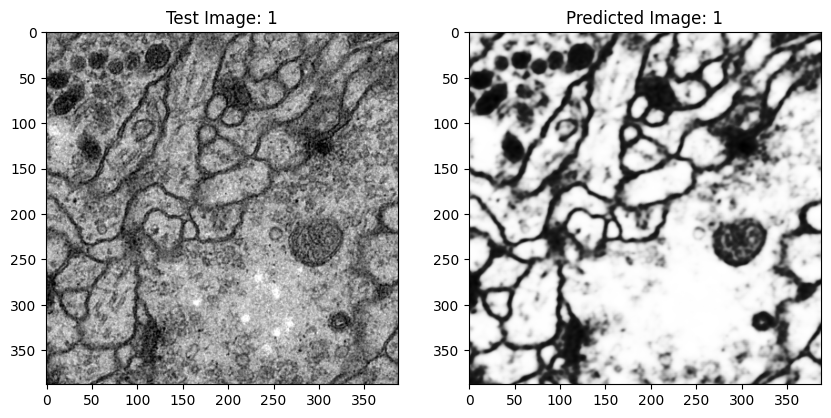

In [38]:
test_image_index = 1

predictions = []
test_tensor = torch.from_numpy(test_images_process[test_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(test_images_process[test_image_index], (388, 388))), cmap='gray')
plt.title(f'Test Image: {test_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(make_grid(prediction.cpu())[0].numpy(), cmap='gray')
plt.title(f'Predicted Image: {test_image_index}')
plt.show()